In [2]:
from flygym.mujoco.arena import BaseArena, FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain
from flygym.mujoco.examples.obstacle_arena import ObstacleOdorArena
from flygym.mujoco.examples.turning_controller import HybridTurningNMF

from gymnasium.utils.env_checker import check_env

from IPython.display import Video
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed
from flygym.mujoco import Parameters
from flygym.mujoco.arena import FlatTerrain

In [3]:
run_time = 1
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, render_mode="saved", render_playspeed=0.2, draw_contacts=True
)
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

In [4]:
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add visual and olfactory features on top of it
arena = ObstacleOdorArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (12.5, 5), (17.5, 0)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.2, 0.8, 0.2, 1), (0.2, 0.2, 0.8, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
)

(-0.5, 639.5, 479.5, -0.5)

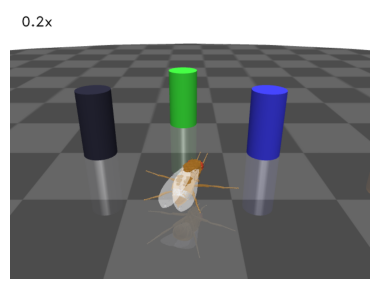

In [5]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(13, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
)

for i in range(1):
    obs, reward, terminated, truncated, info = nmf.step(np.zeros(2))
    nmf.render()

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(nmf._frames[-1])
ax.axis("off")

In [6]:
# generate the video with the pillars
# check_env(nmf)

obs, info = nmf.reset()
for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i * nmf.sim_params.timestep
    if curr_time < 1:
        action = np.array([1.2, 0.2])
    else:
        action = np.array([0.2, 1.2])

    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/pillars.mp4")
Video("./outputs/pillars.mp4")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [03:20<00:00, 49.75it/s]


In [22]:
# Create a new class to generate 2 big walls next to the fly
from typing import Union, Tuple, List, Optional, Callable

class ObstacleWallsArena(BaseArena):
    num_sensors = 4

    def __init__(
        self,
        terrain: BaseArena,
        obstacle_positions: np.ndarray = np.array([(7.5, 0), (12.5, 5), (17.5, -5)]),
        obstacle_colors: Union[np.ndarray, Tuple] = (0, 0, 0, 1),
        obstacle_x: float = 1,
        obstacle_y: float = 50,
        obstacle_z: float = 50,

        obstacle_height: float = 4,
        odor_source: np.ndarray = np.array([[25, 0, 2]]),
        peak_intensity: np.ndarray = np.array([[1]]),
        diffuse_func: Callable = lambda x: x**-2,
        marker_colors: Optional[List[Tuple[float, float, float, float]]] = None,
        marker_size: float = 0.1,
        user_camera_settings: Optional[
            Tuple[Tuple[float, float, float], Tuple[float, float, float], float]
        ] = None,
    ):
        self.terrain_arena = terrain
        self.obstacle_positions = obstacle_positions
        self.root_element = terrain.root_element
        self.friction = terrain.friction
        self.obstacle_x = obstacle_x # largeur
        self.obstacle_y = obstacle_y # longeur
        self.obstacle_z = obstacle_z # hauteur

        z_offset = terrain.get_spawn_position(np.zeros(3), np.zeros(3))[0][2]
        obstacle_colors = np.array(obstacle_colors)
        if obstacle_colors.shape == (4,):
            obstacle_colors = np.array(
                [obstacle_colors for _ in range(obstacle_positions.shape[0])]
            )
        else:
            assert obstacle_colors.shape == (obstacle_positions.shape[0], 4)

        self.odor_source = np.array(odor_source)
        self.peak_odor_intensity = np.array(peak_intensity)
        self.num_odor_sources = self.odor_source.shape[0]
        if self.odor_source.shape[0] != self.peak_odor_intensity.shape[0]:
            raise ValueError(
                "Number of odor source locations and peak intensities must match."
            )
        self.odor_dim = self.peak_odor_intensity.shape[1]
        self.diffuse_func = diffuse_func

        # Add markers at the odor sources
        if marker_colors is None:
            rgb = np.array([255, 127, 14]) / 255
            marker_colors = [(*rgb, 1)] * self.num_odor_sources
            num_odor_sources = self.odor_source.shape[0]
        self.marker_colors = marker_colors
        self._odor_marker_geoms = []
        for i, (pos, rgba) in enumerate(zip(self.odor_source, marker_colors)):
            pos = list(pos)
            pos[2] += z_offset
            marker_body = self.root_element.worldbody.add(
                "body", name=f"odor_source_marker_{i}", pos=pos, mocap=True
            )
            geom = marker_body.add(
                "geom", type="capsule", size=(marker_size, marker_size), rgba=rgba
            )
            self._odor_marker_geoms.append(geom)

        # Reshape odor source and peak intensity arrays to simplify future claculations
        _odor_source_repeated = self.odor_source[:, np.newaxis, np.newaxis, :]
        _odor_source_repeated = np.repeat(_odor_source_repeated, self.odor_dim, axis=1)
        _odor_source_repeated = np.repeat(
            _odor_source_repeated, self.num_sensors, axis=2
        )
        self._odor_source_repeated = _odor_source_repeated
        _peak_intensity_repeated = self.peak_odor_intensity[:, :, np.newaxis]
        _peak_intensity_repeated = np.repeat(
            _peak_intensity_repeated, self.num_sensors, axis=2
        )
        self._peak_intensity_repeated = _peak_intensity_repeated

        # Add obstacles
        self.obstacle_bodies = []
        obstacle_material = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.obstacle_z_pos = z_offset + obstacle_height / 2
        for i in range(obstacle_positions.shape[0]):
            obstacle_pos = [*obstacle_positions[i, :], self.obstacle_z_pos]
            obstacle_color = obstacle_colors[i]
            obstacle_body = self.root_element.worldbody.add(
                "body", name=f"obstacle_{i}", mocap=True, pos=obstacle_pos
            )
            self.obstacle_bodies.append(obstacle_body)
            obstacle_body.add(
                "geom",
                type="box",
                size=(obstacle_x, obstacle_y, obstacle_z),
                pos=(0, 0, 0),
                rgba=obstacle_color,
                material=obstacle_material,
            )

        # Add monitor cameras
        self.side_cam = self.root_element.worldbody.add(
            "camera",
            name="side_cam",
            mode="fixed",
            pos=(odor_source[0, 0] / 2, -25, 10),
            euler=(np.deg2rad(75), 0, 0),
            fovy=50,
        )
        self.back_cam = self.root_element.worldbody.add(
            "camera",
            name="back_cam",
            mode="fixed",
            pos=(-9, 0, 7),
            euler=(np.deg2rad(60), 0, -np.deg2rad(90)),
            fovy=55,
        )
        self.birdeye_cam = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam",
            mode="fixed",
            pos=(7.5, 0, 25),
            euler=(0, 0, 0),
            fovy=45,
        )
        self.birdeye_cam_origin = self.root_element.worldbody.add(
            "camera",
            name="birdeye_cam_origin",
            mode="fixed",
            pos=(0, 0, 40),
            euler=(0, 0, 0),
            fovy=50,
        )
        if user_camera_settings is not None:
            cam_pos, cam_euler, cam_fovy = user_camera_settings
            self.root_element.worldbody.add(
                "camera",
                name="user_cam",
                mode="fixed",
                pos=cam_pos,
                euler=cam_euler,
                fovy=cam_fovy,
            )
        
    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return self.terrain_arena.get_spawn_position(rel_pos, rel_angle)

    def get_olfaction(self, antennae_pos: np.ndarray) -> np.ndarray:
        antennae_pos_repeated = antennae_pos[np.newaxis, np.newaxis, :, :]
        dist_3d = antennae_pos_repeated - self._odor_source_repeated  # (n, k, w, 3)
        dist_euc = np.linalg.norm(dist_3d, axis=3)  # (n, k, w)
        scaling = self.diffuse_func(dist_euc)  # (n, k, w)
        intensity = self._peak_intensity_repeated * scaling  # (n, k, w)
        return intensity.sum(axis=0)  # (k, w)

    def pre_visual_render_hook(self, physics):
        for geom, rgba in zip(self._odor_marker_geoms, self.marker_colors):
            physics.bind(geom).rgba = np.array([*rgba[:3], 0])

    def post_visual_render_hook(self, physics):
        for geom, rgba in zip(self._odor_marker_geoms, self.marker_colors):
            physics.bind(geom).rgba = np.array([*rgba[:3], 1])

In [23]:
# We start by creating a simple arena
flat_terrain_arena = FlatTerrain()

# Then, we add walls features on top of it
arena = ObstacleWallsArena(
    terrain=flat_terrain_arena,
    obstacle_positions=np.array([(7.5, 0), (17.5, 0)]),
    marker_size=0.5,
    obstacle_colors=[(0.14, 0.14, 0.2, 1), (0.14, 0.14, 0.2, 1)],
    user_camera_settings=((13, -18, 9), (np.deg2rad(65), 0, 0), 45),
    
)

(-0.5, 639.5, 479.5, -0.5)

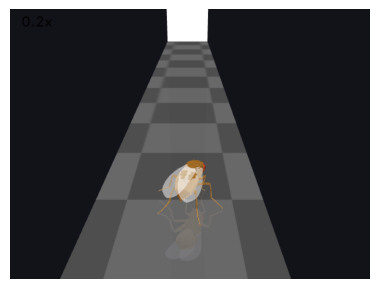

In [24]:
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    render_playspeed=0.2,
    render_camera="user_cam",
    enable_vision=True,
    render_raw_vision=True,
    enable_olfaction=True,
)
nmf = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(13, -5, 0.2),
    spawn_orientation=(0, 0, np.pi / 2 + np.deg2rad(70)),
    contact_sensor_placements=contact_sensor_placements,
)

for i in range(500):
    obs, reward, terminated, truncated, info = nmf.step(np.zeros(2))
    nmf.render()

fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.imshow(nmf._frames[-1])
ax.axis("off")

In [21]:
# generate the video with the 2 big walls

obs, info = nmf.reset()
for i in trange(int(run_time / nmf.sim_params.timestep)):
    curr_time = i * nmf.sim_params.timestep
    if curr_time < 1:
        action = np.array([1.2, 0.2])
    else:
        action = np.array([0.2, 1.2])

    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/walls.mp4")
Video("./outputs/walls.mp4")

100%|██████████| 10000/10000 [02:44<00:00, 60.92it/s]
